<a href="https://colab.research.google.com/github/vivek-varma/Volatality_Prediction_ML/blob/main/TCN_Model_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip -q install torch torchvision torchaudio

import os, math, json, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import balanced_accuracy_score, f1_score, classification_report, confusion_matrix, log_loss
from sklearn.utils.class_weight import compute_class_weight
from google.colab import drive
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [2]:
SEQ_LEN     = 60        # lookback days
EPOCHS      = 500
BATCH_TRAIN = 128
BATCH_EVAL  = 256
PATIENCE    = 200
SEED        = 1337

DATA_DIR = "/content/drive/MyDrive/Regime_pred/Data"
OUT_DIR  = "/content/drive/MyDrive/Regime_pred/Models/Deep_TCN"
CSV_PATH = f"{DATA_DIR}/REGIME_FEATURES_DAILY_LABELED.csv"

In [3]:
drive.mount('/content/drive', force_remount=False)
os.makedirs(OUT_DIR, exist_ok=True)

def set_seed(seed=SEED):
    import random, numpy as np, torch
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed); torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Device: cuda


In [4]:
df = pd.read_csv(CSV_PATH, parse_dates=["date"]).sort_values("date").reset_index(drop=True)
print("Rows:", len(df), "| Date range:", df.date.min().date(), "→", df.date.max().date())
print("Class counts:", df["regime_y"].value_counts().to_dict())


Rows: 3478 | Date range: 2018-01-08 → 2024-12-31
Class counts: {2: 1182, 0: 1148, 1: 1148}


In [5]:
drop_cols = ["date", "regime_y", "RV_t1"]
X = df.drop(columns=[c for c in drop_cols if c in df.columns]).copy()
y = df["regime_y"].astype(int).values


In [6]:
obj_cols = X.select_dtypes(include=["object"]).columns.tolist()
for c in obj_cols:
    X[c] = X[c].astype("category").cat.codes.replace(-1, np.nan)

# Fill small gaps safely
X = X.fillna(method="ffill").fillna(method="bfill")
feature_names = X.columns.tolist()
X = X.values.astype(np.float32)

/tmp/ipython-input-529496445.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = X.fillna(method="ffill").fillna(method="bfill")


In [7]:
n = len(df)
n_train = int(math.floor(n * 0.60))
n_val   = int(math.floor(n * 0.20))
idx_train = np.arange(0, n_train)
idx_val   = np.arange(n_train, n_train + n_val)
idx_test  = np.arange(n_train + n_val, n)


In [8]:
 # lookback days

def make_sequences(Xa, ya, idx):
    xs, ys, keep_dates = [], [], []
    for i in idx:
        if i - SEQ_LEN + 1 < 0:
            continue
        xs.append(Xa[i-SEQ_LEN+1:i+1, :])  # [SEQ_LEN, n_feat]
        ys.append(ya[i])
        keep_dates.append(df.iloc[i]["date"])
    return np.stack(xs), np.array(ys), pd.to_datetime(keep_dates)

# Standardize using TRAIN ONLY
std_scaler = StandardScaler()
std_scaler.fit(X[idx_train])
Xz = std_scaler.transform(X).astype(np.float32)

Xtr_seq, ytr, dates_tr = make_sequences(Xz, y, idx_train)
Xva_seq, yva, dates_va = make_sequences(Xz, y, idx_val)
Xte_seq, yte, dates_te = make_sequences(Xz, y, idx_test)

print("Sequences:", "Train", Xtr_seq.shape, "| Val", Xva_seq.shape, "| Test", Xte_seq.shape)

Sequences: Train (2027, 60, 22) | Val (695, 60, 22) | Test (697, 60, 22)


In [9]:
print("Sequences -> Train:", Xtr_seq.shape, "| Val:", Xva_seq.shape, "| Test:", Xte_seq.shape)

Sequences -> Train: (2027, 60, 22) | Val: (695, 60, 22) | Test: (697, 60, 22)


In [10]:
class SeqDS(Dataset):
    def __init__(self, Xseq, y):
        # Convert to [N, C, T] for Conv1d (channels-first)
        self.X = torch.from_numpy(Xseq).permute(0, 2, 1).contiguous()
        self.y = torch.from_numpy(y).long()
    def __len__(self): return len(self.y)
    def __getitem__(self, i): return self.X[i], self.y[i]

train_ds = SeqDS(Xtr_seq, ytr)
val_ds   = SeqDS(Xva_seq, yva)
test_ds  = SeqDS(Xte_seq, yte)

BATCH = 64
train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True, drop_last=False, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=128, shuffle=False, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=128, shuffle=False, pin_memory=True)


In [11]:
class Chomp1d(nn.Module):
    def __init__(self, chomp_size): super().__init__(); self.chomp_size = chomp_size
    def forward(self, x): return x[:, :, :-self.chomp_size].contiguous()

class TemporalBlock(nn.Module):
    def __init__(self, in_ch, out_ch, k, dilation, padding, dropout=0.1):
        super().__init__()
        self.conv1 = nn.Conv1d(in_ch, out_ch, k, padding=padding, dilation=dilation)
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.drop1 = nn.Dropout(dropout)

        self.conv2 = nn.Conv1d(out_ch, out_ch, k, padding=padding, dilation=dilation)
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.drop2 = nn.Dropout(dropout)

        self.downsample = nn.Conv1d(in_ch, out_ch, 1) if in_ch != out_ch else None
        self.final_relu = nn.ReLU()

    def forward(self, x):
        y = self.conv1(x); y = self.chomp1(y); y = self.relu1(y); y = self.drop1(y)
        y = self.conv2(y); y = self.chomp2(y); y = self.relu2(y); y = self.drop2(y)
        res = x if self.downsample is None else self.downsample(x)
        return self.final_relu(y + res)

class TCN(nn.Module):
    def __init__(self, in_ch, num_classes, channels=(64,64,64), k=3, dropout=0.1):
        super().__init__()
        layers, ch_in = [], in_ch
        for i, ch_out in enumerate(channels):
            dilation = 2 ** i
            padding = (k - 1) * dilation
            layers.append(TemporalBlock(ch_in, ch_out, k, dilation, padding, dropout))
            ch_in = ch_out
        self.backbone = nn.Sequential(*layers)
        self.head = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(ch_in, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, num_classes),
        )

    def forward(self, x):
        z = self.backbone(x)
        return self.head(z)

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

num_classes = int(np.unique(y).size)
model = TCN(in_ch=Xtr_seq.shape[2], num_classes=num_classes, channels=(64,64,64), k=3, dropout=0.10).to(device)

Device: cuda


In [13]:
classes_sorted = np.sort(np.unique(ytr))
cls_weights = compute_class_weight(class_weight="balanced", classes=classes_sorted, y=ytr)
# Map weights into a dense tensor indexed by class id (0..num_classes-1)
w_vec = np.zeros(num_classes, dtype=np.float32)
for i, c in enumerate(classes_sorted): w_vec[int(c)] = cls_weights[i]
criterion = nn.CrossEntropyLoss(weight=torch.tensor(w_vec, dtype=torch.float32, device=device))

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-3, weight_decay=1e-4)
sched = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

# Mixed precision for GPU speed
amp_scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

/tmp/ipython-input-325629885.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  amp_scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())


In [14]:
def eval_loader(loader):
    model.eval()
    ys, ps = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
            with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
                logits = model(xb)
                prob = torch.softmax(logits, dim=1)
            ys.append(yb.cpu().numpy())
            ps.append(prob.cpu().numpy())
    y_true = np.concatenate(ys)
    p = np.concatenate(ps)
    y_pred = p.argmax(1)
    return y_true, y_pred, p

best_val = np.inf
patience = 20
wait = 0
best_path = os.path.join(OUT_DIR, "tcn_best.pt")

In [15]:
def eval_loader(loader):
    model.eval()
    ys, ps = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
            # New autocast API
            with torch.amp.autocast("cuda", enabled=torch.cuda.is_available()):
                logits = model(xb)
                prob = torch.softmax(logits, dim=1)
            ys.append(yb.cpu().numpy())
            ps.append(prob.cpu().numpy())
    y_true = np.concatenate(ys); p = np.concatenate(ps)
    return y_true, p.argmax(1), p

best_val = np.inf
wait = 0
best_path = os.path.join(OUT_DIR, "tcn_best.pt")

for epoch in range(1, EPOCHS+1):
    model.train()
    running = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        with torch.amp.autocast("cuda", enabled=torch.cuda.is_available()):
            logits = model(xb)
            loss = criterion(logits, yb)
        amp_scaler.scale(loss).backward()
        # clip grads for stability
        amp_scaler.unscale_(optimizer)
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        amp_scaler.step(optimizer)
        amp_scaler.update()
        running += loss.item() * xb.size(0)

    train_loss = running / len(train_ds)
    sched.step()

    yv_true, yv_pred, yv_proba = eval_loader(val_loader)
    val_loss = log_loss(yv_true, yv_proba, labels=np.arange(num_classes))

    if val_loss < best_val:
        best_val, wait = val_loss, 0

        # Save weights
        torch.save({"model": model.state_dict()}, best_path)

        # Save the *feature* scaler stats used earlier
        with open(os.path.join(OUT_DIR, "tcn_scaler.json"), "w") as f:
            json.dump({
                "mean": std_scaler.mean_.tolist(),
                "scale": std_scaler.scale_.tolist(),
                "feature_names": feature_names,
                "seq_len": SEQ_LEN
            }, f, indent=2)
    else:
        wait += 1

    print(f"Epoch {epoch:02d} | train_loss {train_loss:.4f} | val_logloss {val_loss:.4f} | best {best_val:.4f} | wait {wait}/{PATIENCE}")
    if wait >= PATIENCE:
        print("Early stopping.")
        break

print("Best val logloss:", round(best_val, 4))

Epoch 01 | train_loss 0.9722 | val_logloss 0.9441 | best 0.9441 | wait 0/200
Epoch 02 | train_loss 0.9104 | val_logloss 1.0309 | best 0.9441 | wait 1/200
Epoch 03 | train_loss 0.8774 | val_logloss 1.2436 | best 0.9441 | wait 2/200
Epoch 04 | train_loss 0.8448 | val_logloss 1.3143 | best 0.9441 | wait 3/200
Epoch 05 | train_loss 0.7985 | val_logloss 0.9581 | best 0.9441 | wait 4/200
Epoch 06 | train_loss 0.7582 | val_logloss 1.1621 | best 0.9441 | wait 5/200
Epoch 07 | train_loss 0.7431 | val_logloss 1.0162 | best 0.9441 | wait 6/200
Epoch 08 | train_loss 0.7327 | val_logloss 0.9666 | best 0.9441 | wait 7/200
Epoch 09 | train_loss 0.7184 | val_logloss 1.0141 | best 0.9441 | wait 8/200
Epoch 10 | train_loss 0.7351 | val_logloss 1.1022 | best 0.9441 | wait 9/200
Epoch 11 | train_loss 0.7033 | val_logloss 1.0253 | best 0.9441 | wait 10/200
Epoch 12 | train_loss 0.7142 | val_logloss 1.3730 | best 0.9441 | wait 11/200
Epoch 13 | train_loss 0.6846 | val_logloss 1.1231 | best 0.9441 | wait 12/

In [16]:
ckpt = torch.load(best_path, map_location=device)
model.load_state_dict(ckpt["model"])

ytest_true, ytest_pred, ytest_proba = eval_loader(test_loader)
test_balacc = balanced_accuracy_score(ytest_true, ytest_pred)
test_f1m    = f1_score(ytest_true, ytest_pred, average="macro")
test_rep    = classification_report(ytest_true, ytest_pred, digits=3, zero_division=0)
test_cm     = confusion_matrix(ytest_true, ytest_pred, labels=np.arange(num_classes))
test_ll     = log_loss(ytest_true, ytest_proba, labels=np.arange(num_classes))

print("\n=== TEST RESULTS (TCN) ===")
print("LogLoss:", round(test_ll, 4))
print("Balanced Acc:", round(test_balacc, 4))
print("Macro F1:", round(test_f1m, 4))
print("\nClassification Report:\n", test_rep)


=== TEST RESULTS (TCN) ===
LogLoss: 1.8158
Balanced Acc: 0.4347
Macro F1: 0.4106

Classification Report:
               precision    recall  f1-score   support

           0      0.542     0.279     0.368       326
           1      0.382     0.573     0.458       267
           2      0.367     0.452     0.405       104

    accuracy                          0.418       697
   macro avg      0.430     0.435     0.411       697
weighted avg      0.454     0.418     0.408       697



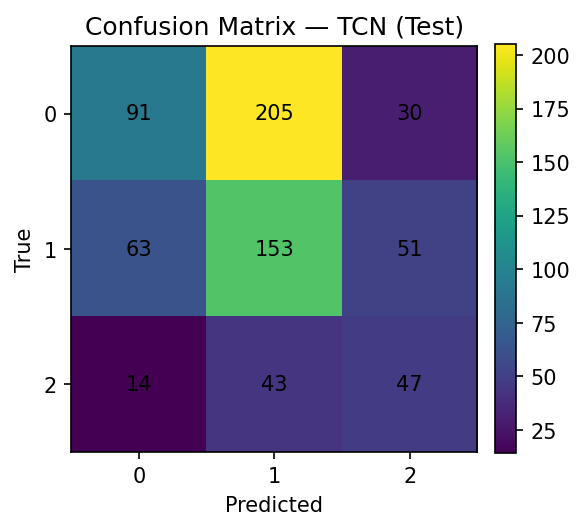


✅ Saved in /content/drive/MyDrive/Regime_pred/Models/Deep_TCN:
 - tcn_best.pt (weights)
 - tcn_scaler.json (means/scales + feature names + seq_len)
 - tcn_test_metrics.json
 - tcn_test_predictions.csv
 - tcn_confusion_matrix.png


In [17]:
with open(os.path.join(OUT_DIR, "tcn_test_metrics.json"), "w") as f:
    json.dump({"logloss": float(test_ll), "balanced_acc": float(test_balacc), "macro_f1": float(test_f1m)}, f, indent=2)

# Predictions
pd.DataFrame({"date": dates_te.date, "y_true": ytest_true, "y_pred": ytest_pred}).to_csv(
    os.path.join(OUT_DIR, "tcn_test_predictions.csv"), index=False)

# Confusion matrix plot
fig, ax = plt.subplots(figsize=(4,4), dpi=150)
im = ax.imshow(test_cm, interpolation="nearest")
ax.set_title("Confusion Matrix — TCN (Test)")
ax.set_xticks(range(num_classes)); ax.set_yticks(range(num_classes))
ax.set_xticklabels(range(num_classes)); ax.set_yticklabels(range(num_classes))
ax.set_xlabel("Predicted"); ax.set_ylabel("True")
for i in range(test_cm.shape[0]):
    for j in range(test_cm.shape[1]):
        ax.text(j, i, test_cm[i, j], ha="center", va="center")
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "tcn_confusion_matrix.png"))
plt.show()

print(f"\n✅ Saved in {OUT_DIR}:")
print(" - tcn_best.pt (weights)")
print(" - tcn_scaler.json (means/scales + feature names + seq_len)")
print(" - tcn_test_metrics.json")
print(" - tcn_test_predictions.csv")
print(" - tcn_confusion_matrix.png")